<a href="https://colab.research.google.com/github/nirnayroy/2d-billiards/blob/master/Copy_of_2d_billiards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fermi Acceleration in 2d-billiards

# Imports

In [ ]:
!pip install shapely

In [ ]:
#@title
import numpy as np
from scipy import optimize
from scipy.misc import derivative
import matplotlib.pyplot as plt
import pickle 

from shapely.geometry import LineString
from shapely.geometry import Point

# Some functions

In [ ]:
#slit position
def slit(t, s, omega):
    return -s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


# Travel for rectangle with slit

In [ ]:

#mapping function from one state to the next  
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


In [ ]:

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


In [ ]:

def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


In [ ]:

omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
    dbfile = open('ensemble2_100', 'ab') 
      
    # source, destination 
    pickle.dump(systems, dbfile)                      
    dbfile.close()
    return systems



In [ ]:

systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)


In [ ]:
import matplotlib.pyplot as plt
def load_and_plot(time_step=1):
    
    dbfile = open('ensemble2', 'rb')      
    systems = pickle.load(dbfile) 
    
    t = 1
    
    tfs = []
    for i in systems:
        last_state = i[len(i)-1]
        #print(last_state)
        (x, y, u, v, tm) = last_state
        tfs.append(tm)
    
    tf = min(tfs)
     
    #print(tf)
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<t2 and t>t1:
                    v += ((v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        #print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

[4333.7531107363575, 4620.855276032316, 5166.599944930533, 5699.88178690181, 6123.237379250558, 6342.2125597567365, 6350.904854983463, 6856.617443316063, 7486.465641915043, 8012.077270917688, 8486.73231278515, 8652.635143721285, 9491.019845687464, 9577.259902409387, 10287.677709275411, 10466.46170717086, 11347.304446746577, 12545.698230169282, 14024.503667592347, 14909.898383584286, 17242.622126118804, 18677.013810298922, 20508.175033088428, 23931.24883240195, 21108.74190138676, 21780.135594746956, 23576.32517277359, 23678.46022377276, 26002.784754953438, 27028.108758986356, 30821.53984096212, 30936.95811236209, 29092.146627217953, 31125.56130226421, 30880.65087704504, 31982.442207685974]
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501]


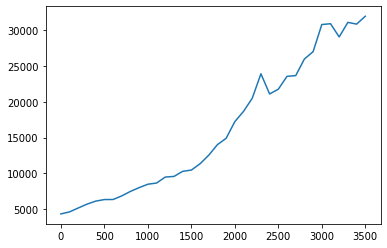

In [ ]:
load_and_plot(time_step=100)

In [ ]:
import pickle 
dbfile = open('ensemble2_100', 'rb')      
systems = pickle.load(dbfile) 

FileNotFoundError: [Errno 2] No such file or directory: 'ensemble2_100'

# Trapezium Billiards

In [ ]:
def line2cord(m, x_0, h, x):
    c = x_0 - (h/m)
    return (m*x)+c

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))

def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    k = 0
    while True:
        p = Point(0,h)
        c = p.buffer(l).boundary

        x_left = -l
        x_right = l
        m = vel_vec[1]/vel_vec[0]
        y_left = line2cord(m , x, h, x_left)
        y_right = line2cord(m , x, h, x_right)
        l = LineString([(x_left,y_left), (x_right, y_right)])
        i = c.intersection(l)

        pois = [(i.geoms[0].coords[0]), (i.geoms[1].coords[0])]
        if pois[0][1]>h != pois[1][1]>h:
            if pois[0][1]>h:
                x_ =  pois[0][0]
            else:
                x_ =  pois[1][0]
            if (x_ - x)/vel_vec[0] < 0:
                print('t dec')
            t += (x_ - x)/vel_vec[0]
            x =  x_
            y = sem_func(x, r)
            k += 1
            nor_vec = [-1, d_sem_func(x, r)]
            nor_vec /= np.linalg.norm(nor_vec)
            vel_vec = -vel_vec + (2*np.dot(vel_vec, nor_vec)*nor_vec)
            if k==0:
                #first collision
                pass
            else:
                #last collision
                #give end point
                del_t = ((h-y)/vel_vec[1])
                if del_t < 0:
                    print('t dec_2')
                t += del_t
                x += vel_vec[0]*del_t
                y = h
                break

        elif (pois[0][1]>h and pois[1][1]>h) and (k>0):
            #collision inside
            sol1 = pois[0][0]
            sol2 = pois[1][0]
            if x == sol1:
                t += (x - sol2)/vel_vec[0]
                x = sol2
                y = sem_func(x, r)
            elif x == sol2:
                t += (x - sol1)/vel_vec[0]
                x = sol1
                y = sem_func(x, r)
            else:
                print('no intersection')


        else:
            #error
            print('err3')
        k+=1

    '''
        
        a = 1+ ((vel_vec[1]/vel_vec[0])**2)
        b = -2*x
        c = ((x**2) - (r**2))
        disc = (b**2) - (4*a*c)
        #y = sem_func(x, r)
        print('x:', x, 'y:', y)
        nor_vec = [-1, d_sem_func(x, r)]
        nor_vec /= np.linalg.norm(nor_vec)
        vel_vec = -vel_vec + (2*np.dot(vel_vec, nor_vec)*nor_vec)

        if disc == 0:
            if k == 0:  
                t += (x - (b/(2*a)))/vel_vec[0]
                x =  (-b) / 2*a
                y = sem_func(x, r)
                k += 1
                print('first_collision: x:', x, 'y:', y)
            else:
                del_t = ((y-h)/vel_vec[1])
                t += del_t
                x += vel_vec[0]*del_t
                y = h
                print('last_collision: x:', x, 'y:', y)
                break

        elif disc > 0 and k >0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            if x == sol1:
                t += (x - sol2)/vel_vec[0]
                x = sol2
                y = sem_func(x, r)
            else:
                t += (x - sol1)/vel_vec[0]
                x = sol1
                y = sem_func(x, r)
            print('collision: x:', x, 'y:', y, 'k:', k, 'sol1:', sol1, 'sol2:'
            , sol2)
            k += 1
        else:
            print('something wrong')
            print('disc:', disc, 'k:', k, 'a:', a, 'b:', b , 'c:', c)
            break
    '''
    return (x, y, vel_vec[0], vel_vec[1], t)

#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , uf, -vf, tf, lam, l, h, s, omega)
            if yf != h:
                print('err1') 

        else:
            yf = -h
            #print('next wall: bottom')
    '''
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
    '''
   
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


    


next wall: semi-circle enclosure
err3


ArgumentError: ignored

In [ ]:
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


# Stadium Billiards